In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [3]:
# imports
path_to_prep_mum = 'data/data_prepared/mums_prep.csv'
path_to_prep_dad = 'data/data_prepared/dads_prep.csv'
df_dads = pd.read_csv(path_to_prep_dad)
df_dads['dad_value_numeric_rescale'] = df_dads.dad_value_numeric /10**6


path_to_prepared_data = 'data/data_prepared/only_stalions_prepared.csv'
df = pd.read_csv(path_to_prepared_data)
df.head()

,Unnamed: 0,kid_id,mum_id,dad_id,value_numeric,first_place,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts
0,0,1,D1,S2,132570.0,8,156410.0,9.0,1.0,0.0,10.0
1,2,3,D1,S3,631605.0,11,1749869.0,43.0,8.0,5.0,66.0
2,3,4,D1,S4,8963.0,1,580806.0,14.0,2.0,2.0,18.0
3,4,5,D1,S4,4799.0,1,580806.0,14.0,2.0,2.0,18.0
4,7,58,D9,S5,209211.0,14,1176781.0,21.0,7.0,3.0,32.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         40 non-null     int64  
 1   kid_id             40 non-null     int64  
 2   mum_id             40 non-null     object 
 3   dad_id             40 non-null     object 
 4   value_numeric      40 non-null     float64
 5   first_place        40 non-null     int64  
 6   dad_value_numeric  40 non-null     float64
 7   dad_first_place    40 non-null     float64
 8   dad_second_place   40 non-null     float64
 9   dad_third_place    40 non-null     float64
 10  dad_num_of_starts  40 non-null     float64
dtypes: float64(6), int64(3), object(2)
memory usage: 3.6+ KB


In [5]:
# rescaling values
for column in ['value_numeric', 'dad_value_numeric']:
    new_col = column + '_rescale'
    df[new_col] = df[column]/10**6
df.head()

,Unnamed: 0,kid_id,mum_id,dad_id,value_numeric,first_place,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts,value_numeric_rescale,dad_value_numeric_rescale
0,0,1,D1,S2,132570.0,8,156410.0,9.0,1.0,0.0,10.0,0.132570,0.156410
1,2,3,D1,S3,631605.0,11,1749869.0,43.0,8.0,5.0,66.0,0.631605,1.749869
2,3,4,D1,S4,8963.0,1,580806.0,14.0,2.0,2.0,18.0,0.008963,0.580806
3,4,5,D1,S4,4799.0,1,580806.0,14.0,2.0,2.0,18.0,0.004799,0.580806
4,7,58,D9,S5,209211.0,14,1176781.0,21.0,7.0,3.0,32.0,0.209211,1.176781


# histogram of data we want to predict

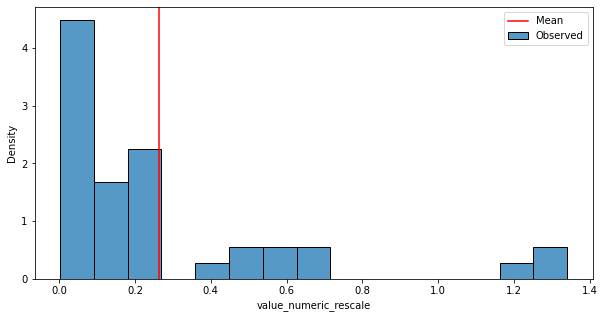

In [6]:
# analysis of value: what we want to to predict
fig, axs = plt.subplots(1,1, figsize=(10,5))
graph = sns.histplot(data=df, x='value_numeric_rescale', bins=15, ax=axs, label='Observed', stat='density')
graph.axvline(df.value_numeric_rescale.mean(), color='red', label='Mean')
graph.legend()
plt.show()

# histograms of data we want to predict from


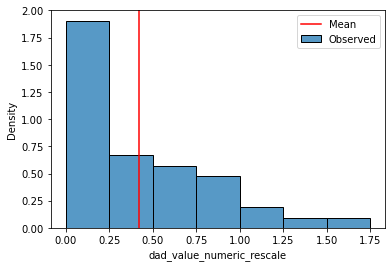

In [7]:
# histograms of data we want to predict from
graph = sns.histplot(data=df_dads, x='dad_value_numeric_rescale', label='Observed', stat='density')
graph.axvline(df_dads.dad_value_numeric_rescale.mean(), color='red', label='Mean')
graph.legend()
plt.show()

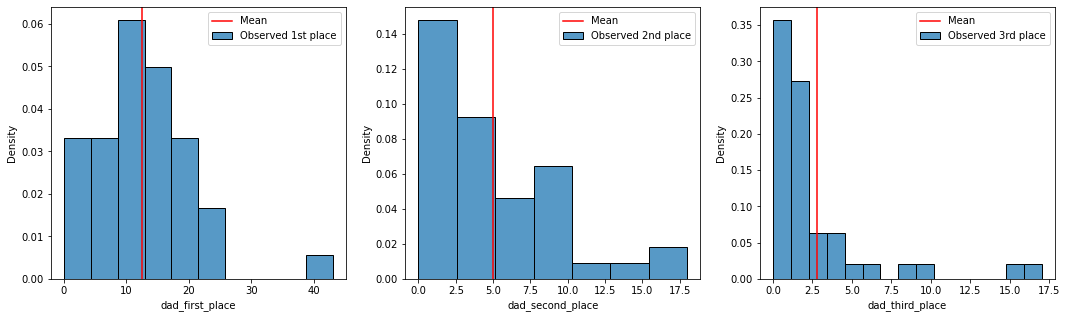

In [8]:
# places of dad
fig, axs = plt.subplots(1,3, figsize=(18,5))
graph = sns.histplot(data=df_dads, x='dad_first_place', label='Observed 1st place', ax=axs[0], stat='density')
graph.axvline(df_dads.dad_first_place.mean(), color='red', label='Mean')
graph.legend()

graph = sns.histplot(data=df_dads, x='dad_second_place', label='Observed 2nd place', ax=axs[1], stat='density')
graph.axvline(df_dads.dad_second_place.mean(), label='Mean', color='red')
graph.legend()

graph = sns.histplot(data=df_dads, x='dad_third_place', label='Observed 3rd place', ax=axs[2], stat='density')
graph.axvline(df_dads.dad_third_place.mean(), label='Mean', color='red')
graph.legend()
plt.show()

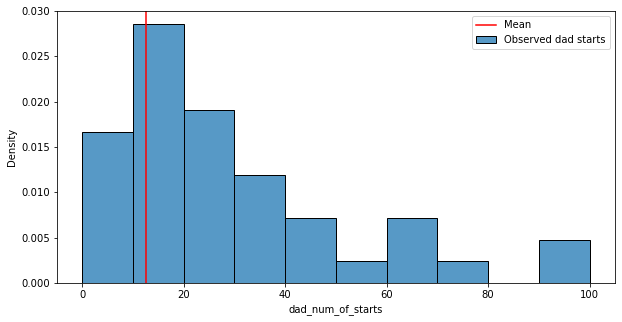

In [9]:
# nums of starts
fig, axs = plt.subplots(1,1, figsize=(10,5))
graph = sns.histplot(data=df_dads, x='dad_num_of_starts', label='Observed dad starts', ax=axs, bins=10, stat='density')
graph.axvline(df_dads.dad_first_place.mean(), color='red', label='Mean')
graph.legend()
plt.show()


Assumed prior distributions:
- `dad_num_of_starts` : lognormal
- `dad_value_numeric_rescale` : exponential
- `dad_first_place` : lognormal
- `dad_second_place` : exponential
- `dad_third_place` : expnoential

In [13]:
# calculating needed parameters for prior distributions
# to use in stan models in a bit

# dad_num_of_starts
mu_dad_num_of_starts = df_dads.dad_num_of_starts.mean()
sigma_dad_num_of_starts = df_dads.dad_num_of_starts.std()

# dad_value_numeric_rescale
lambda_dad_value_numeric_rescale = 1/df_dads.dad_value_numeric_rescale.mean()

# dad_first_place
mu_dad_first_place = df_dads.dad_first_place.mean()
sigma_dad_first_place = df_dads.dad_first_place.std()

# dad_second_place
lambda_dad_second_place = 1/df_dads.dad_second_place.mean()

# dad_third_place
lambda_dad_third_place = 1/df_dads.dad_third_place.mean()

